# 1. Higgs@L3_BDT

## Prerequisites
This notebook does not need any data from other code executions.
It can be run directly after downloading the data sets.

## BDT training
A BDT is trained for each of the Higgs mass hypothesis.

## BDT evaluation
Later on, some plots descibing a BDT are produced.

## Tree visualtization
Independently from the previous calculations, a simple tree visualtization is performed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from sklearn.ensemble import GradientBoostingClassifier

from higgs_search.helpers import higgs_hypotheses, symbol
from higgs_search.load_data import getTrainAndTest
from higgs_search.plotting import confusionMatrix

## Obtain a classifier for each mass hypothesis

In [2]:
def fitClassifier(higgs_mass):
    grbcl = GradientBoostingClassifier(max_depth=3, random_state=0,
        learning_rate=0.01,
        n_estimators=300,
    )
    print("A classifier with the following parameters will be fitted "
        f"for the mass hypothesis {higgs_mass}:\n\n", grbcl.get_params())
    X_train, X_test, y_train, y_test, X_train_w, X_test_w = getTrainAndTest(higgs_mass, upweight_signal=True)
    grbcl.fit(X_train, y_train, sample_weight=X_train_w)
    return grbcl

def getClassifier(higgs_mass):
    bdt_path = f"tmp/BDT_{higgs_mass}.pkl"
    if not os.path.exists(bdt_path):
        grbcl = fitClassifier(higgs_mass)
        with open(bdt_path, "wb") as fid:
            pickle.dump(grbcl, fid)  
    else:
        with open(bdt_path, "rb") as fid:
            grbcl = pickle.load(fid)
    return grbcl

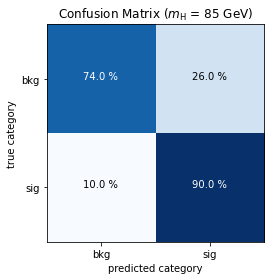

higgs_85 training score: 89.10 %.
higgs_85 test set score: 88.50 %.



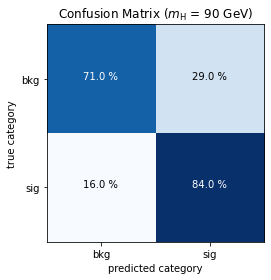

higgs_90 training score: 88.19 %.
higgs_90 test set score: 85.47 %.



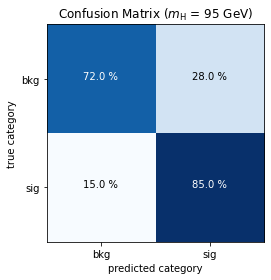

higgs_95 training score: 87.44 %.
higgs_95 test set score: 84.41 %.



In [12]:
bdts = {}
for higgs_mass in higgs_hypotheses:
    bdts[higgs_mass] = getClassifier(higgs_mass)
    X_train, X_test, y_train, y_test, X_train_w, X_test_w = getTrainAndTest(higgs_mass, upweight_signal=True)

    y_pred = bdts[higgs_mass].predict(X_test)
    confusionMatrix(y_pred, y_test)
    plt.title(f"Confusion Matrix ($m_\mathrm{{H}}$ = {higgs_mass[-2:]} GeV)")
    plt.savefig(f"plots/bdt_confusion_matrix_{higgs_mass}.png", facecolor="white")
    plt.show()

    print(f"{higgs_mass} training score: {100*bdts[higgs_mass].score(X_train, y_train, sample_weight=X_train_w):.2f} %.")
    print(f"{higgs_mass} test set score: {100*bdts[higgs_mass].score(X_test, y_test, sample_weight=X_test_w):.2f} %.\n")

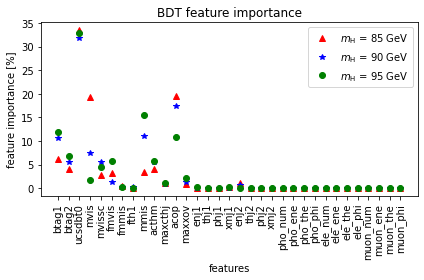

In [13]:
for higgs_mass, bdt in bdts.items():
    plt.plot(100*bdt.feature_importances_, symbol[higgs_mass], 
             label=f"$m_\mathrm{{H}}$ = {higgs_mass[-2:]} GeV")
plt.title("BDT feature importance")
plt.xlabel("features")
plt.ylabel("feature importance [%]")
plt.xticks(np.arange(len(X_train.columns)), X_train.columns, rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig("plots/bdt_feature_importance.png", facecolor="white")

## Look further into the Gradient Boosting Classifiers

### The BDT response

In [5]:
def getSigBkgTrainTestSplit(higgs_mass, bdt):
    X_train, X_test, y_train, y_test, X_train_w, X_test_w = getTrainAndTest(higgs_mass, upweight_signal=True)

    train_bkg = bdt.decision_function(X_train[y_train == 0])
    train_sig = bdt.decision_function(X_train[y_train == 1])
    test_bkg = bdt.decision_function(X_test[y_test == 0])
    test_sig = bdt.decision_function(X_test[y_test == 1])

    return train_bkg, train_sig, test_bkg, test_sig

def getHistograms(train_bkg, train_sig, test_bkg, test_sig):
    binning = np.linspace(
        min((min(b) for b in [train_bkg, train_sig, test_bkg, test_sig])),
        max((max(b) for b in [train_bkg, train_sig, test_bkg, test_sig])),
        30,
    )
    x = (binning[1:] + binning[:-1]) / 2.
    w = binning[1] - binning[0]

    h_train_bkg = np.histogram(train_bkg, bins=binning)[0]
    h_train_sig = np.histogram(train_sig, bins=binning)[0]


    h_test_bkg = np.histogram(test_bkg, bins=binning)[0]
    h_test_sig = np.histogram(test_sig, bins=binning)[0]
    return x, w, h_train_bkg, h_train_sig, h_test_bkg, h_test_sig

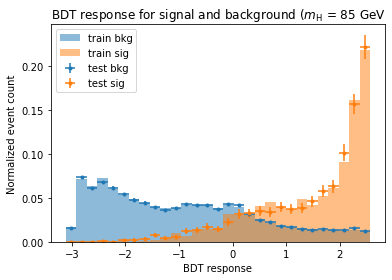

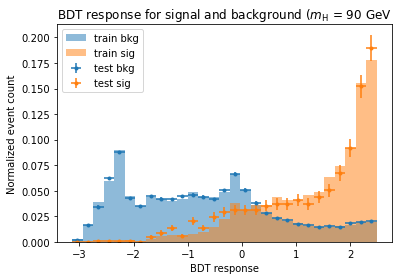

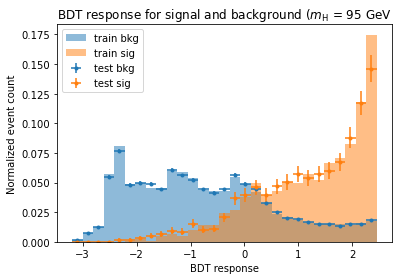

In [14]:
for higgs_mass, bdt in bdts.items():
    train_bkg, train_sig, test_bkg, test_sig = getSigBkgTrainTestSplit(higgs_mass, bdt)
    x, w, h_train_bkg, h_train_sig, h_test_bkg, h_test_sig = getHistograms(train_bkg, train_sig, test_bkg, test_sig)

    plt.bar(x, h_train_bkg/len(train_bkg), width=w, label="train bkg", alpha=0.5)
    plt.bar(x, h_train_sig/len(train_sig), width=w, label="train sig", alpha=0.5)
    plt.errorbar(x, h_test_bkg/len(test_bkg),
                 xerr=w/2., yerr=np.sqrt(h_test_bkg)/len(test_bkg),
                 label="test bkg", fmt=".")
    plt.errorbar(x, h_test_sig/len(test_sig),
                 xerr=w/2., yerr=np.sqrt(h_test_sig)/len(test_sig),
                label="test sig", fmt='.')

    plt.xlabel("BDT response")
    plt.ylabel("Normalized event count")
    plt.legend()
    plt.title(f"BDT response for signal and background ($m_\mathrm{{H}}$ = {higgs_mass[-2:]} GeV")
    plt.savefig(f"plots/bdt_generalization_performance_{higgs_mass}.png", facecolor="white")
    plt.show()

### Efficiency & purity

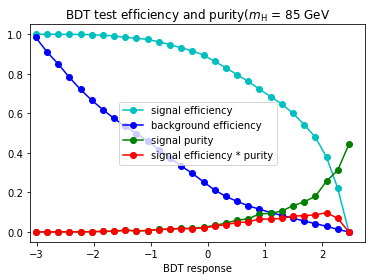

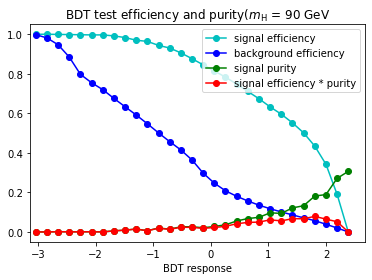

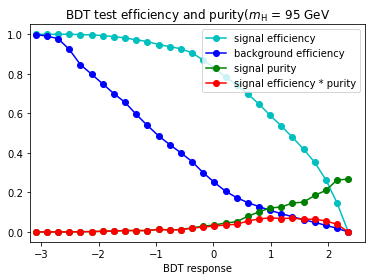

In [15]:
for higgs_mass, bdt in bdts.items():
    train_bkg, train_sig, test_bkg, test_sig = getSigBkgTrainTestSplit(higgs_mass, bdt)
    x, w, h_train_bkg, h_train_sig, h_test_bkg, h_test_sig = getHistograms(train_bkg, train_sig, test_bkg, test_sig)

    sig_eff = 1 - np.cumsum(h_test_sig)/len(test_sig)
    bkg_eff = 1 - np.cumsum(h_test_bkg)/len(test_bkg)
    sig_pur = h_test_sig / (h_test_sig + h_test_bkg)

    eff_pur = sig_eff * sig_pur
    plt.plot(x, sig_eff, "co-", label="signal efficiency")
    plt.plot(x, bkg_eff, "bo-", label="background efficiency")
    plt.plot(x, sig_pur, "go-", label="signal purity")
    plt.plot(x, eff_pur, "ro-", label="signal efficiency * purity")
    plt.legend()
    plt.xlabel("BDT response")
    plt.xlim(min(x)-w/2, max(test_sig)+w)
    plt.title(f"BDT test efficiency and purity($m_\mathrm{{H}}$ = {higgs_mass[-2:]} GeV")
    plt.savefig(f"plots/bdt_eff_purity_{higgs_mass}.png", facecolor="white")
    plt.show()

## Appendix: Visualization of a  Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

In [17]:
X_train, X_test, y_train, y_test, X_train_w, X_test_w = getTrainAndTest("higgs_85", upweight_signal=True)
tree = DecisionTreeClassifier(max_depth=2,random_state=0)
tree.fit(X_train, y_train, sample_weight=X_train_w.values)

DecisionTreeClassifier(max_depth=2, random_state=0)

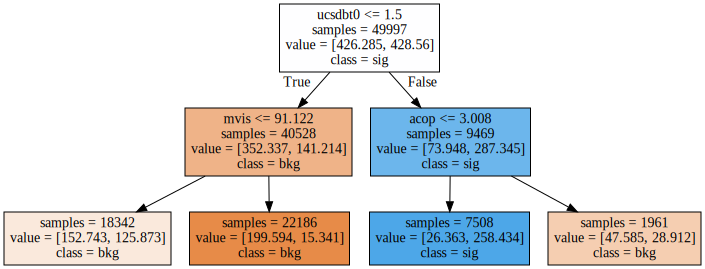

In [18]:
export_graphviz(tree, out_file="plots/tree.dot", 
    class_names=["bkg", "sig"], feature_names=X_train.columns, 
    impurity=False, filled=True
)

with open("plots/tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)